In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# time management
import datetime as dt
# visualisation
import matplotlib.pyplot as plt

In [2]:
data_raw = pd.read_csv('Data/raw_data_sinaica.csv')
data_raw.head()
# clean data, erase the null
data_raw.dropna(inplace=True)
# ordenar en base a la Estación de menor a mayor
data_raw.sort_values(by='Estación', inplace=True)
# imprimir las estaciones
print(data_raw['Estación'].unique())
# cambiar el indice para que sea en base a la Time usando
data_raw.set_index('Time', inplace=True) 
# convert time to datetime

FileNotFoundError: [Errno 2] No such file or directory: 'DataJuarez/raw_data_sinaica.csv'

In [4]:
data_raw.

,Estación,CO,DV,HR,NO,NO2,NOx,O3,PB,PM10,PM2.5,PP,RS,SO2,TMP,VV
Time,,,,,,,,,,,,,,,,
2022-02-06 05:00:00,Pesquería,0.15,288.0,69.0,0.007,0.016,0.022,0.010,734.0,16.0,-9999.0,0.0,-9999.0,0.001,1.90,0.278
2022-02-13 05:00:00,Pesquería,0.16,310.0,70.0,0.017,0.017,0.033,0.009,742.0,31.0,-9999.0,0.0,-9999.0,0.002,5.00,0.278
2022-02-15 16:00:00,Pesquería,0.10,123.0,31.0,0.005,0.006,0.010,0.047,730.0,22.0,-9999.0,0.0,595.0,0.008,24.40,4.528
2022-02-20 05:00:00,Pesquería,0.17,235.0,83.0,0.007,0.006,0.013,0.019,735.0,4.0,-9999.0,0.0,-9999.0,0.002,9.80,0.278
2022-03-20 05:00:00,Pesquería,0.26,126.0,73.0,0.008,0.008,0.016,0.019,734.0,50.0,-9999.0,0.0,-9999.0,0.002,12.00,0.278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05 12:00:00,Juárez,1.45,293.0,14.0,0.032,0.045,0.077,0.025,722.0,119.0,29.0,0.0,358.0,0.013,26.81,0.278
2022-01-05 15:00:00,Juárez,1.25,137.0,14.0,0.008,0.040,0.048,0.100,720.9,73.0,29.0,0.0,256.0,0.017,29.45,1.889
2022-01-05 16:00:00,Juárez,1.07,123.0,15.0,0.004,0.029,0.033,0.127,720.8,81.0,28.0,0.0,68.0,0.031,29.02,2.778


In [5]:
# para cada variable, eliminar las filas que tengan numeros menores a 0, excepto para la columna estacion y la columna time
for col in data_raw.columns:
    if col != 'Estación' and col != 'Time':
        data_raw = data_raw[data_raw[col] >= 0]

In [6]:
data_raw.head()

,Estación,CO,DV,HR,NO,NO2,NOx,O3,PB,PM10,PM2.5,PP,RS,SO2,TMP,VV
Time,,,,,,,,,,,,,,,,
2022-01-01 01:00:00,Juárez,3.18,19.0,71.0,0.028,0.030,0.059,0.011,719.3,511.0,0.0,0.0,0.0,0.005,20.87,0.194
2022-01-01 08:00:00,Juárez,1.77,220.0,68.0,0.019,0.022,0.041,0.008,719.6,150.0,124.0,0.0,8.0,0.004,17.76,0.333
2022-01-01 11:00:00,Juárez,1.02,297.0,28.0,0.007,0.013,0.020,0.022,720.1,123.0,58.0,0.0,309.0,0.004,30.24,0.222
2022-01-01 12:00:00,Juárez,0.65,342.0,18.0,0.003,0.003,0.007,0.027,720.0,138.0,13.0,0.0,344.0,0.003,33.30,0.333
2022-01-01 13:00:00,Juárez,0.65,353.0,16.0,0.004,0.004,0.008,0.030,719.7,61.0,10.0,0.0,326.0,0.003,34.45,0.333


In [7]:
# contar cuantos datos hay de cada Estacion
data_raw.groupby('Estación').count()

,CO,DV,HR,NO,NO2,NOx,O3,PB,PM10,PM2.5,PP,RS,SO2,TMP,VV
Estación,,,,,,,,,,,,,,,
Cadereyta,3425,3425,3425,3425,3425,3425,3425,3425,3425,3425,3425,3425,3425,3425,3425
Escobedo,3235,3235,3235,3235,3235,3235,3235,3235,3235,3235,3235,3235,3235,3235,3235
García,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535,2535
Juárez,3663,3663,3663,3663,3663,3663,3663,3663,3663,3663,3663,3663,3663,3663,3663
Obispado,2854,2854,2854,2854,2854,2854,2854,2854,2854,2854,2854,2854,2854,2854,2854


In [8]:
# ir dato por dato checando si no hay saltos de hora
counter = 0
# un arreglo de length = len(data_raw) donde marcaremos si hay saltos de hora
saltos = np.zeros(len(data_raw))
for i in range(len(data_raw)):
    if i == 0:
        pass
    else:
        # checar el indice de la fila actual para sacar la hora y marcar el error si hay un salto distinto de 1 hora con datetime
        if (dt.datetime.strptime(data_raw.index[i], '%Y-%m-%d %H:%M:%S') - dt.datetime.strptime(data_raw.index[i-1], '%Y-%m-%d %H:%M:%S')).seconds != 3600:
            counter += 1
            saltos[i] = 1
print ("hubieron {} errores de salto de hora".format(counter),"de un total de {} filas".format(len(data_raw)))
# crear un arreglo con la distancia entre cada 1 del arreglo saltos
prev = 0
new = 0
pares = []
for i in range(len(saltos)):
    if saltos[i] == 1:
        new = i
        pares.append([prev,new])
        prev = new
# drop the last pair
pares.pop()

hubieron 1468 errores de salto de hora de un total de 15712 filas


[15682, 15688]

1468

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
print(data_raw.mean(axis=0))
data_raw.describe()

CO         1.609189
DV       110.334394
HR        50.301808
NO         0.008380
NO2        0.012294
NOx        0.020662
O3         0.030248
PB       717.044851
PM10      68.502164
PM2.5     24.025140
PP         0.000000
RS       190.039588
SO2        0.006185
TMP       23.849824
VV         2.578618
dtype: float64


C:\Users\Felipe de Jesus\AppData\Local\Temp\ipykernel_13092\2441390554.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_raw.mean(axis=0))


,CO,DV,HR,NO,NO2,NOx,O3,PB,PM10,PM2.5,PP,RS,SO2,TMP,VV
count,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.000000,15712.0,15712.000000,15712.000000,15712.000000,15712.000000
mean,1.609189,110.334394,50.301808,0.008380,0.012294,0.020662,0.030248,717.044851,68.502164,24.025140,0.0,190.039588,0.006185,23.849824,2.578618
std,0.565277,86.364713,21.554765,0.018256,0.009703,0.025114,0.019376,10.808983,42.298049,15.959043,0.0,324.433414,0.007311,7.830789,1.463992
min,0.000000,1.000000,0.000000,0.002000,0.001000,0.003000,0.001000,680.700000,0.000000,0.000000,0.0,0.000000,0.003000,0.100000,0.028000
25%,1.280000,45.000000,33.000000,0.003000,0.006000,0.009000,0.016000,709.600000,44.000000,13.000000,0.0,0.000000,0.004000,19.017500,1.444000
50%,1.540000,97.000000,51.000000,0.004000,0.009000,0.013000,0.027000,718.800000,59.000000,20.000000,0.0,33.000000,0.005000,24.660000,2.417000
75%,1.810000,130.000000,69.000000,0.006000,0.016000,0.022000,0.041000,724.300000,80.000000,32.000000,0.0,266.000000,0.006000,29.320000,3.556000
max,6.870000,360.000000,92.000000,0.381000,0.083000,0.401000,0.150000,747.600000,594.000000,172.000000,0.0,1894.000000,0.190000,43.150000,8.083000


In [11]:
# definir entrada y salida
data = data_raw.drop(columns=['Estación']).to_numpy()
# entrada y salida
X_input,Y_output = data[:-1,:],data[1:,:]
# estandarizar los datos
X_input = (X_input - X_input.mean(axis=0)) / X_input.std(axis=0)
Y_output = (Y_output - Y_output.mean(axis=0)) / Y_output.std(axis=0)
# llenar los nan con 0
X_input = np.nan_to_num(X_input)
Y_output = np.nan_to_num(Y_output)
X_train, X_test, Y_train, Y_test = train_test_split(X_input, Y_output, test_size=0.15, shuffle=False)
X_train, X_test, Y_train, Y_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(Y_train).float(), torch.from_numpy(Y_test).float()
print ("Tamaño de X_train: {}".format(X_train.shape))
print ("Tamaño de X_test: {}".format(X_test.shape))
print ("Tamaño de Y_train: {}".format(Y_train.shape))
print ("Tamaño de Y_test: {}".format(Y_test.shape))
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

Tamaño de X_train: torch.Size([13354, 15])
Tamaño de X_test: torch.Size([2357, 15])
Tamaño de Y_train: torch.Size([13354, 15])
Tamaño de Y_test: torch.Size([2357, 15])


C:\Users\Felipe de Jesus\AppData\Local\Temp\ipykernel_13092\2775976340.py:6: RuntimeWarning: invalid value encountered in true_divide
  X_input = (X_input - X_input.mean(axis=0)) / X_input.std(axis=0)
C:\Users\Felipe de Jesus\AppData\Local\Temp\ipykernel_13092\2775976340.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_output = (Y_output - Y_output.mean(axis=0)) / Y_output.std(axis=0)


In [12]:
input_size = 5
hidden_size = 5
num_layers = 3
batch_size = 5
seq_len = 6
lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
input_size_t = (batch_size,seq_len,input_size)
# make input sample
inputs = torch.zeros(input_size_t)
# make hidden state
hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
# forward
output, hidden = lstm(inputs, hidden)
print (output.shape)
print (hidden[0].shape)
print (hidden[1].shape)

torch.Size([5, 6, 5])
torch.Size([3, 5, 5])
torch.Size([3, 5, 5])


In [54]:
# definir la red neuronal
class O3Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers_lstm,num_layers_lin, dropout=0.1):
        super(O3Net, self).__init__()
        # Lstm (Long Short Term Memory) with num_layers_lstm layers 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers_lstm = num_layers_lstm
        self.num_layers_lin = num_layers_lin
        self.dropout = dropout
        # definir el modelo
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers_lstm, dropout=dropout, batch_first=True)
        linear = []
        # linear layers with num_layers_lin layers
        for i in range(num_layers_lin):
            linear.append(nn.Linear(hidden_size, hidden_size))
            linear.append(nn.GELU())
            #linear.append(nn.Dropout(dropout))
        self.linear = nn.Sequential(*linear)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.Dropout = nn.Dropout(dropout)
    def forward(self, x, future=0):
        # input shape: (batch_size, seq_len, input_size)
        # initialize hidden state with Xavier Uniform
        hidden = self.init_hidden(x.size(0))
        # Shape: (num_layers, batch_size, hidden_size)
        out_hidden, _ = self.lstm(x, hidden)
        # Shape: (batch_size, seq_len, hidden_size)
        out_linear = self.linear(out_hidden)
        # Shape: (batch_size, seq_len, output_size)
        out_linear1 = self.fc1(out_linear)
        # Shape: (batch_size, seq_len, output_size)
        Out_Relu = out_linear1
        # Shape: (batch_size, seq_len, output_size)
        Out_Dropout = self.Dropout(Out_Relu)
        # Shape: (batch_size, seq_len, output_size)
        out = Out_Dropout[:,-1:,:]
        hidden = (_[0], _[1])
        #print (_[0].shape)
        #print (_[1].shape)
        #print (out_hidden.shape)
        # make prediction
        Pred = []
        for i in range(future):
            out,_ = self.lstm(out, hidden)
            out = self.linear(out)
            out = self.fc1(out)
            out = self.Dropout(out)
            #print ("out:",out.shape)
            Pred.append(out)
        # concatenate the predictions
        if future != 0 :
            Pred = torch.cat(Pred, dim = 1)
            # Shape: (batch_size, future, output_size)
            # concatenate the output and the predictions
            #print (Pred.shape)
            #print (Out_Dropout.shape)
            out = torch.cat((Out_Dropout, Pred), 1)
        # Shape: (batch_size, seq_len + future, output_size)
        return out
    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.num_layers_lstm, batch_size, self.hidden_size).to(device), torch.zeros(self.num_layers_lstm, batch_size, self.hidden_size).to(device))
        # initialize hidden state with Xavier Uniform
        return hidden


In [55]:
# definir un ejemplo de entrada
#input_sample = torch.zeros(1,4,len(data_raw.columns) - 1)
# definir un ejemplo de salida
#output = Model(input_sample, future=20)

In [56]:
# definir los parametros de la red
Parameters = {
    'input_size': len(data_raw.columns) - 1,
    'hidden_size': 32,
    'output_size': len(data_raw.columns) - 1,
    'num_layers_lstm': 3,
    'num_layers_lin': 3,
    'dropout': 0.01
}
Model = O3Net(**Parameters).to(device)
# pararmetros de entrenamiento

In [57]:

learning_rate = 0.1
num_epochs = 100
batch_size = 1
temperature = 0.1
clip = .5
batch_size = 1
seq_len = 6
Porcentaje_prediccion = 0.7
# definir el optimizador
optimizer = torch.optim.AdamW(Model.parameters(), lr=learning_rate,weight_decay=0.1)
# definir el criterio de pérdida
criterion = nn.MSELoss()

In [58]:
from math import ceil, floor
from tqdm import tqdm
Tol = 10

def train_step():
    # all with the device
    count = 0
    loss_history = []
    tot_loss = 0
    optimizer.zero_grad()
    # ir entre los intervalos de los saltos en los pares
    print ("Step.. ",end="")
    for i in pares:
        # print (i)
        # checar si el intervalo es mayor a un grado de tolerancia Tol
        if abs(i[1] - i[0]) > Tol and i[1] < len(X_train):
            #print ("intervalo mayor a Tol:", abs(i[1] - i[0]))
            # agarrar el intervalo de datos de entrenamiento
            inter = i[1] - i[0]  
            context, future = floor(inter * (1 - Porcentaje_prediccion)), ceil(inter * Porcentaje_prediccion)
            X_inter,y_inter = X_train[i[0]:i[0]+context].unsqueeze(0),Y_train[i[0]:i[0]+inter].unsqueeze(0)
            # hacer el input de la red con X_inter
           
            output = Model(X_inter, future=future)
            #print ("output:",output.shape)
            loss = criterion(output, y_inter)
            count += 1
            tot_loss += loss
            # clip gradients
            loss_history.append(loss.item())
    tot_loss = tot_loss / count
    tot_loss.backward()
    torch.nn.utils.clip_grad_norm_(Model.parameters(), clip)
    optimizer.step()
    #print ("intervalos mayores a Tol:", count, " de ", len(pares))
    return tot_loss


In [59]:
def evaluate(model, X_test, Y_test):
    # make a prediction
    with torch.no_grad():
        y_pred = model(X_test[0:500].unsqueeze(0), future=100)
    # calculate the loss
    y = y_pred.cpu().detach().numpy()[0]
    y_real = Y_test[0:600].cpu().numpy()
    #plt.plot(np.y[:,0], label = "Prediccion")
    print ("y_pred:",y.shape)
    print ("y_real:",y_real.shape)
    # add a line for the real data
    plt.axvline(x=500, color='r', linestyle='--', label = "Real")
    plt.plot(np.arange(len(y_real)), y_real[:,6], label = "Real")
    plt.plot(np.arange(len(y)), y[:,6], label = "Prediccion",alpha=0.8)
    plt.legend()
    plt.show()

Step.. epoch: 0 loss: 0.9600513577461243
-----------------------------------------------------
y_pred: (600, 15)
y_real: (600, 15)


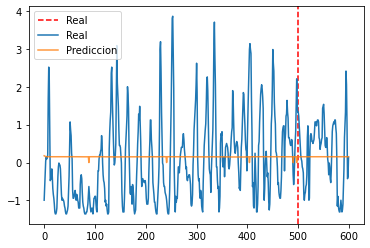

Step.. Step.. Step.. Step.. Step.. epoch: 5 loss: 1.0059282779693604
-----------------------------------------------------
y_pred: (600, 15)
y_real: (600, 15)


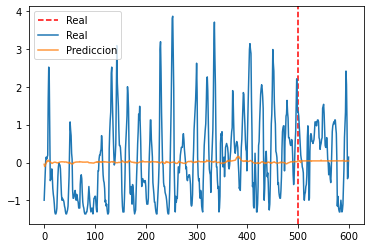

Step.. Step.. 

KeyboardInterrupt: 

In [60]:
history_loss = []
for epoch in range(num_epochs):
    loss = train_step()
    history_loss.append(loss)
    if epoch % 5 == 0:
        print ("epoch:",epoch,"loss:",loss.item())
        print ("-----------------------------------------------------")
        evaluate(Model, X_test, Y_test)

In [20]:
# salvar el modelo
torch.save(Model.state_dict(), 'model5.pt')

y_pred: (600, 15)
y_real: (600, 15)


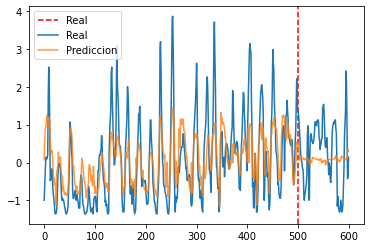

In [29]:
evaluate(Model, X_test, Y_test)

In [54]:
tot_list = []
for losst in history_loss:
    tot_list.append(losst.item())

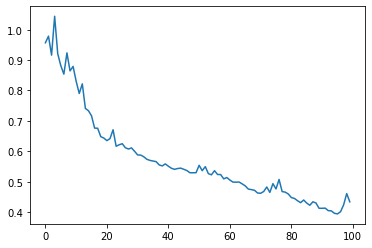

In [55]:
# plot loss
plt.plot(tot_list)
plt.show()

In [56]:
# save tot_list np
np.save("tot_list4.npy",tot_list)